<a href="https://colab.research.google.com/github/RodrigodeFeo/8DTS/blob/main/Aula_5_DTS_PLN_Demo_IA_Generativa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Demostração - Aula 5**

Até aqui vimos como usar **word embeddings generativos** (pré-treinados) focando em análise de similaridade e manuseio do espaço vetorial de alguns algoritmos como Word2Vec.

E se tentarmos usar essa "inteligència" para resolver nosso problema de classificação?

###**Análise com skip-gram em Português**

In [7]:
# Download Word Embeddings Pré-treinadas em Portugûes (skip-gram)
# Repositório original: http://nilc.icmc.usp.br/nilc/index.php/repositorio-de-word-embeddings-do-nilc

In [8]:
# Download do arquivo no repositório do professor
!wget 'https://dados-ml-pln.s3-sa-east-1.amazonaws.com/skip_s300.zip'

# Descompactação do arquivo
!unzip 'skip_s300.zip' # subistitua com nome do arquivo
!ls -la

--2024-05-18 14:55:07--  https://dados-ml-pln.s3-sa-east-1.amazonaws.com/skip_s300.zip
Resolving dados-ml-pln.s3-sa-east-1.amazonaws.com (dados-ml-pln.s3-sa-east-1.amazonaws.com)... 3.5.234.16, 16.12.1.74, 3.5.232.21, ...
Connecting to dados-ml-pln.s3-sa-east-1.amazonaws.com (dados-ml-pln.s3-sa-east-1.amazonaws.com)|3.5.234.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 958619745 (914M) [application/zip]
Saving to: ‘skip_s300.zip’

skip_s300.zip       100%[===================>] 914.21M  18.3MB/s    in 52s     

2024-05-18 14:56:00 (17.7 MB/s) - ‘skip_s300.zip’ saved [958619745/958619745]

Archive:  skip_s300.zip
  inflating: skip_s300.txt           
total 3533272
drwxr-xr-x 1 root root       4096 May 18 14:56 .
drwxr-xr-x 1 root root       4096 May 18 14:52 ..
drwxr-xr-x 4 root root       4096 May 16 13:24 .config
-rw-r--r-- 1 root root    3776170 May 18 14:54 produtos.csv
drwxr-xr-x 1 root root       4096 May 16 13:24 sample_data
-rw-r--r-- 1 root root 26

In [9]:
# Load do modelo pelo Gensim
from gensim.models import KeyedVectors

model_skip = KeyedVectors.load_word2vec_format('skip_s300.txt')

In [10]:
model_skip

Análise de similaridade

In [11]:
model_skip.similarity('maçã', 'uva')

0.6507031

In [12]:
model_skip.similarity('maçã', 'carro')

0.074699655

In [13]:
pairs = [
    ('carro', 'jipe'),
    ('carro', 'avião'),
    ('carro', 'bicicleta'),
    ('carro', 'cereal'),
    ('carro', 'filosofia'),
]
for w1, w2 in pairs:
    print('%r\t%r\t%.2f' % (w1, w2, model_skip.similarity(w1, w2)))

'carro'	'jipe'	0.71
'carro'	'avião'	0.50
'carro'	'bicicleta'	0.55
'carro'	'cereal'	0.08
'carro'	'filosofia'	-0.01


In [14]:
model_skip.most_similar(positive=['carro', 'jipe'], topn=3)

[('furgão', 0.7599552273750305),
 ('caminhão', 0.7516525387763977),
 ('veículo', 0.7478904724121094)]

In [15]:
model_skip.doesnt_match(['fogo', 'água', 'terra', 'mar', 'ar', 'carro'])

'carro'

In [16]:
model_skip.most_similar(positive=['rainha', 'homem'], negative=['mulher'], topn=3)

[('rei', 0.5894271731376648),
 ('monarca', 0.49123090505599976),
 ('guardião', 0.46204233169555664)]

In [17]:
model_skip.most_similar(positive=['rei', 'mulher'], negative=['homem'], topn=10)

[('rainha', 0.660095751285553),
 ('consorte', 0.6526049375534058),
 ('esposa', 0.6504772305488586),
 ('sobrinha', 0.6446163654327393),
 ('princesa', 0.6398769617080688),
 ('filha', 0.6342788338661194),
 ('rainha-viúva', 0.6339502334594727),
 ('primogénita', 0.6332842707633972),
 ('princesa-eleitora', 0.6240091323852539),
 ('meia-irmã', 0.6229892373085022)]

In [18]:
palavras = ['um', 'dois', 'três', 'quatro', 'dez', 'onze', 'vinte', 'homem', 'mulher', 'marido', 'esposa', 'casa', 'mesa', 'cadeira']

In [19]:
from sklearn.decomposition import PCA
import numpy as np

sample_vectors = np.array([model_skip[palavra] for palavra in palavras])
pca = PCA(n_components=2)
result = pca.fit_transform(sample_vectors)
result

array([[ 0.17956805,  0.18375202],
       [-1.2229358 , -0.09905089],
       [-1.4864911 , -0.1221025 ],
       [-1.5300087 , -0.05887511],
       [-1.7701347 , -0.13250092],
       [-1.5516897 , -0.14122166],
       [-1.7721732 , -0.26937428],
       [ 0.9042849 , -0.42676726],
       [ 1.5513343 , -0.61161923],
       [ 1.4905175 , -1.1370462 ],
       [ 1.9972197 , -1.73543   ],
       [ 1.0187491 ,  0.33234295],
       [ 0.8883214 ,  1.6803375 ],
       [ 1.303439  ,  2.5375557 ]], dtype=float32)

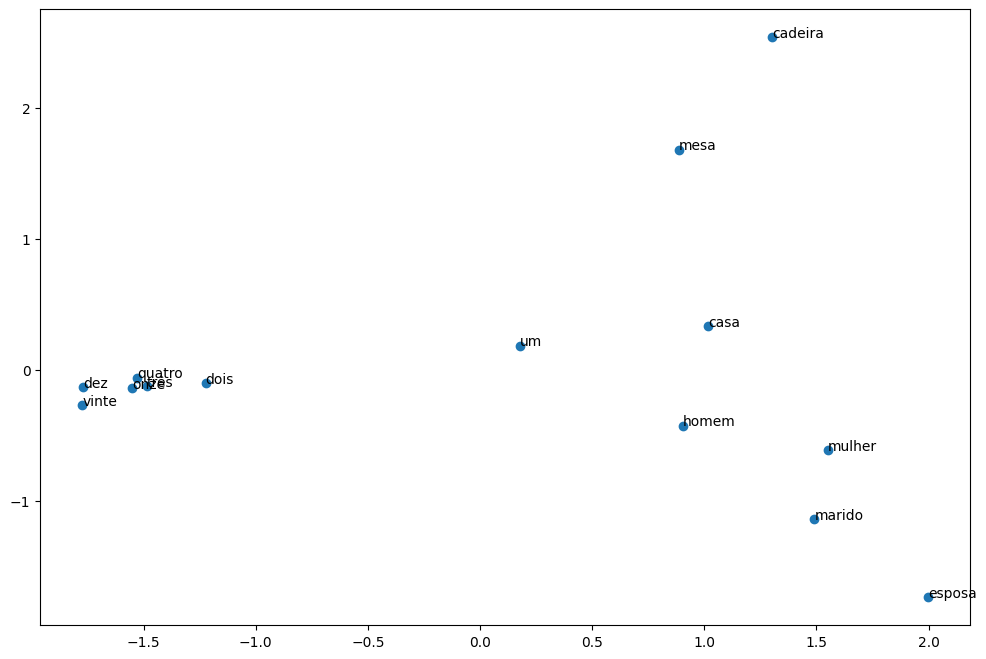

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
plt.scatter(result[:,0], result[:,1])
for i, word in enumerate(palavras):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()

### **Classificador com word2vec**

#### Criando um Dataset com base em reviews

In [21]:
# Install Google play scraper: https://github.com/JoMingyu/google-play-scraper
# Google-Play-Scraper provides APIs to easily crawl the Google Play Store for Python without any external dependencies!
!pip install google_play_scraper

In [22]:
import pandas as pd
from tqdm import tqdm
from google_play_scraper import Sort, reviews, app

In [23]:
apps_ids = [
    'br.com.brainweb.ifood',
    'com.cerveceriamodelo.modelonow',
    'com.mcdo.mcdonalds',
    'habibs.alphacode.com.br',
    'com.xiaojukeji.didi.brazil.customer',
    'com.ubercab.eats',
    'com.grability.rappi',
    'burgerking.com.br.appandroid',
    'com.vanuatu.aiqfome'
    ]

In [24]:
SCORE_SAMPLES = 100
SCORE3_FACTOR = 1; TARGET_COLUMN = 'score'

#TARGET_COLUMN = 'sentiment'; SCORE3_FACTOR = 2

In [25]:
app_reviews = []

for app_id in tqdm(apps_ids):
    for score in list(range(1, 6)):
        for sort_order in [Sort.MOST_RELEVANT, Sort.NEWEST]:
            rvs, _ = reviews(
                app_id,
                lang='pt',
                country='br',
                sort=sort_order,
                count= SCORE3_FACTOR * SCORE_SAMPLES if score == 3 else SCORE_SAMPLES,
                filter_score_with=score
            )
            for r in rvs:
                r['sortOrder'] = 'most_relevant' if sort_order == Sort.MOST_RELEVANT else 'newest'
                r['appId'] = app_id
            app_reviews.extend(rvs)

100%|██████████| 9/9 [00:28<00:00,  3.13s/it]


In [26]:
len(app_reviews)

9000

In [27]:
app_reviews[0]

{'reviewId': 'dd1635bf-88b4-46a5-9c84-0fd922a34cea',
 'userName': 'Bruna Oliveira',
 'userImage': 'https://play-lh.googleusercontent.com/a-/ALV-UjUKzqbDwh_r1RciKODdIWUHGZEUaxNdYntlHiI0s9RFiNOje30',
 'content': 'A opção de substituições do mercado nunca funciona. Mais de 3 vezes eu escolhi a opção de "me envie sugestões" para produtos faltantes, mas mesmo assim, quando escolho o item substituto, ele não altera o pedido, e só me resta cancelar e ficar sem o produto. Além disso, as opções exibidas são limitadas e diferentes do produto escolhido originalmente, deveria ser possível pesquisar exatamente o item que se quer substituir.',
 'score': 1,
 'thumbsUpCount': 25,
 'reviewCreatedVersion': '9.237.0',
 'at': datetime.datetime(2023, 12, 16, 20, 25, 59),
 'replyContent': None,
 'repliedAt': None,
 'appVersion': '9.237.0',
 'sortOrder': 'most_relevant',
 'appId': 'br.com.brainweb.ifood'}

In [28]:
app_reviews_df = pd.DataFrame(app_reviews)

In [29]:
app_reviews_df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,sortOrder,appId
0,dd1635bf-88b4-46a5-9c84-0fd922a34cea,Bruna Oliveira,https://play-lh.googleusercontent.com/a-/ALV-U...,A opção de substituições do mercado nunca func...,1,25,9.237.0,2023-12-16 20:25:59,None,NaT,9.237.0,most_relevant,br.com.brainweb.ifood
1,3b09c1b6-58ed-40f0-a4c9-22a910ffdedf,Leon Tomelin,https://play-lh.googleusercontent.com/a-/ALV-U...,"Nos últimos meses, o aplicativo piorou demais....",1,3273,9.237.0,2023-12-13 23:18:59,None,NaT,9.237.0,most_relevant,br.com.brainweb.ifood
2,6d0a4a48-8b65-4127-9a91-4fdaec57710c,Gizeane Dorte,https://play-lh.googleusercontent.com/a-/ALV-U...,"bem, tive uma experiência decepcionante com o ...",1,183,10.15.0,2024-05-04 04:29:53,None,NaT,10.15.0,most_relevant,br.com.brainweb.ifood
3,b0c8f19d-ce1b-4702-8c4a-b4c23396ae99,Leonardo Peixoto,https://play-lh.googleusercontent.com/a-/ALV-U...,Péssima experiência. Estava fazendo a compra n...,1,22,10.16.0,2024-05-07 15:19:20,None,NaT,10.16.0,most_relevant,br.com.brainweb.ifood
4,bdfac3bf-45e7-4b3d-9376-3eb30bceb085,Fernando Oliveira,https://play-lh.googleusercontent.com/a-/ALV-U...,A experiência é bem ruim. Principalmente pagan...,1,23,10.16.0,2024-05-01 22:09:25,None,NaT,10.16.0,most_relevant,br.com.brainweb.ifood


In [30]:
app_reviews_df['sentiment'] = 0
app_reviews_df.loc[app_reviews_df["score"] < 3, "sentiment"] = -1
app_reviews_df.loc[app_reviews_df["score"] > 3, "sentiment"] = 1

In [31]:
app_reviews_df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,sortOrder,appId,sentiment
0,dd1635bf-88b4-46a5-9c84-0fd922a34cea,Bruna Oliveira,https://play-lh.googleusercontent.com/a-/ALV-U...,A opção de substituições do mercado nunca func...,1,25,9.237.0,2023-12-16 20:25:59,None,NaT,9.237.0,most_relevant,br.com.brainweb.ifood,-1
1,3b09c1b6-58ed-40f0-a4c9-22a910ffdedf,Leon Tomelin,https://play-lh.googleusercontent.com/a-/ALV-U...,"Nos últimos meses, o aplicativo piorou demais....",1,3273,9.237.0,2023-12-13 23:18:59,None,NaT,9.237.0,most_relevant,br.com.brainweb.ifood,-1
2,6d0a4a48-8b65-4127-9a91-4fdaec57710c,Gizeane Dorte,https://play-lh.googleusercontent.com/a-/ALV-U...,"bem, tive uma experiência decepcionante com o ...",1,183,10.15.0,2024-05-04 04:29:53,None,NaT,10.15.0,most_relevant,br.com.brainweb.ifood,-1
3,b0c8f19d-ce1b-4702-8c4a-b4c23396ae99,Leonardo Peixoto,https://play-lh.googleusercontent.com/a-/ALV-U...,Péssima experiência. Estava fazendo a compra n...,1,22,10.16.0,2024-05-07 15:19:20,None,NaT,10.16.0,most_relevant,br.com.brainweb.ifood,-1
4,bdfac3bf-45e7-4b3d-9376-3eb30bceb085,Fernando Oliveira,https://play-lh.googleusercontent.com/a-/ALV-U...,A experiência é bem ruim. Principalmente pagan...,1,23,10.16.0,2024-05-01 22:09:25,None,NaT,10.16.0,most_relevant,br.com.brainweb.ifood,-1


In [32]:
app_reviews_df['sentiment'].value_counts()

sentiment
-1    3600
 1    3600
 0    1800
Name: count, dtype: int64

In [33]:
df_model = app_reviews_df[['content','score','sentiment']]

In [34]:
# Normalização de texto
import string

import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')

# lista de stopwords do NLTK
stopwords = nltk.corpus.stopwords.words('portuguese')

# função que remove pontuação
def remove_punctuation(text):
    punctuations = string.punctuation
    table = str.maketrans({key: " " for key in punctuations})
    text = text.translate(table)
    return text

# função que normaliza o texto e remove stopwords
def norm_tokenize(text):
    text = text.lower()
    text = remove_punctuation(text)
    text = "".join([w for w in text if not w.isdigit()])
    text = word_tokenize(text)
    text = [x for x in text if x not in stopwords]
    text = [y for y in text if len(y) > 2]
    #text " ".join([t for t in text])
    return text

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [35]:
df_model['tokens'] = df_model['content'].apply(norm_tokenize)

<ipython-input-35-a8bb658abe50>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['tokens'] = df_model['content'].apply(norm_tokenize)


In [36]:
df_model.head()

,content,score,sentiment,tokens
0,A opção de substituições do mercado nunca func...,1,-1,"[opção, substituições, mercado, nunca, funcion..."
1,"Nos últimos meses, o aplicativo piorou demais....",1,-1,"[últimos, meses, aplicativo, piorou, demais, v..."
2,"bem, tive uma experiência decepcionante com o ...",1,-1,"[bem, experiência, decepcionante, ifood, recen..."
3,Péssima experiência. Estava fazendo a compra n...,1,-1,"[péssima, experiência, fazendo, compra, mercad..."
4,A experiência é bem ruim. Principalmente pagan...,1,-1,"[experiência, bem, ruim, principalmente, pagan..."


In [37]:
# Exemplo 1: Função para obter embeddings médios para cada texto
vectorizer = model_skip

def average_vector(tokens):
    vector_size = vectorizer.vector_size
    wv_res = np.zeros(vector_size)
    ctr = 1
    for word in tokens:
        if word in vectorizer:
            ctr += 1
            wv_res += vectorizer[word]
    wv_res = wv_res/ctr
    return wv_res

#vectorizer['maquiagem']

In [38]:
# Exemplo 2: Função para obter embeddings médios para cada texto
'''
vectorizer = model_skip

def average_vector(words):
  vectors = [vectorizer[word] for word in words if word in vectorizer]
  if vectors:
    return sum(vectors) / len(vectors)
  else:
    vector_size = vectorizer.vector_size
    wv_res = np.zeros(vector_size)
    return wv_res
'''

'\nvectorizer = model_skip\n\ndef average_vector(words):\n  vectors = [vectorizer[word] for word in words if word in vectorizer]\n  if vectors:\n    return sum(vectors) / len(vectors)\n  else:\n    vector_size = vectorizer.vector_size\n    wv_res = np.zeros(vector_size)\n    return wv_res\n'

In [39]:
# Tokenizar e obter embeddings médios para cada texto
df_model['vector'] = df_model['tokens'].apply(average_vector)

<ipython-input-39-e1e7b11c2590>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['vector'] = df_model['tokens'].apply(average_vector)


In [ ]:
#df_model['vector'][0]

In [40]:
df_model.head()

,content,score,sentiment,tokens,vector
0,A opção de substituições do mercado nunca func...,1,-1,"[opção, substituições, mercado, nunca, funcion...","[0.02483953764805427, -0.06934233234287837, -0..."
1,"Nos últimos meses, o aplicativo piorou demais....",1,-1,"[últimos, meses, aplicativo, piorou, demais, v...","[0.014689348230604082, -0.11228941979975071, -..."
2,"bem, tive uma experiência decepcionante com o ...",1,-1,"[bem, experiência, decepcionante, ifood, recen...","[0.0029845456169410186, -0.0932929086689414, -..."
3,Péssima experiência. Estava fazendo a compra n...,1,-1,"[péssima, experiência, fazendo, compra, mercad...","[0.03358787514152937, -0.1030287496978417, -0...."
4,A experiência é bem ruim. Principalmente pagan...,1,-1,"[experiência, bem, ruim, principalmente, pagan...","[0.0195017689659905, -0.06968943643807553, -0...."


In [41]:
x = df_model['vector'].to_list()
y = df_model[TARGET_COLUMN].to_list()

In [42]:
len(x[0])

300

In [43]:
from sklearn.model_selection import train_test_split
# divisão da amostra entre treino e teste

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y, random_state = 42)

#### Treina modelo

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# treinamento do modelo ávore de decisão com o dataframe de treino
model = RandomForestClassifier(random_state=42)
model.fit(x_train, y_train)

# escoragem da classificação na amostra de teste
y_pred = model.predict(x_test)

In [45]:
# Avaliação do modelo

from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score, confusion_matrix

print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.48      0.59      0.53       540
           2       0.42      0.45      0.43       540
           3       0.41      0.35      0.37       540
           4       0.46      0.37      0.41       540
           5       0.58      0.60      0.59       540

    accuracy                           0.47      2700
   macro avg       0.47      0.47      0.47      2700
weighted avg       0.47      0.47      0.47      2700

0.47185185185185186


#### Comprando o resultado com vetorização Bag of Words

In [46]:
def token_to_text(tokens):
    return " ".join(tokens)

df_model['norm_content'] = df_model['tokens'].apply(token_to_text)

<ipython-input-46-12ec7bc66d6f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['norm_content'] = df_model['tokens'].apply(token_to_text)


In [47]:
df_model.head()

,content,score,sentiment,tokens,vector,norm_content
0,A opção de substituições do mercado nunca func...,1,-1,"[opção, substituições, mercado, nunca, funcion...","[0.02483953764805427, -0.06934233234287837, -0...",opção substituições mercado nunca funciona vez...
1,"Nos últimos meses, o aplicativo piorou demais....",1,-1,"[últimos, meses, aplicativo, piorou, demais, v...","[0.014689348230604082, -0.11228941979975071, -...",últimos meses aplicativo piorou demais vários ...
2,"bem, tive uma experiência decepcionante com o ...",1,-1,"[bem, experiência, decepcionante, ifood, recen...","[0.0029845456169410186, -0.0932929086689414, -...",bem experiência decepcionante ifood recentemen...
3,Péssima experiência. Estava fazendo a compra n...,1,-1,"[péssima, experiência, fazendo, compra, mercad...","[0.03358787514152937, -0.1030287496978417, -0....",péssima experiência fazendo compra mercado adi...
4,A experiência é bem ruim. Principalmente pagan...,1,-1,"[experiência, bem, ruim, principalmente, pagan...","[0.0195017689659905, -0.06968943643807553, -0....",experiência bem ruim principalmente pagando ap...


In [48]:
x = review_embeddings
y = df_model[TARGET_COLUMN].to_list()

NameError: name 'review_embeddings' is not defined

In [49]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

df_train, df_test = train_test_split(
      df_model,
      test_size = 0.3,
      random_state = 42
  )

vect = CountVectorizer()
vect.fit(df_train.norm_content)
x_train = vect.transform(df_train.norm_content)
x_test = vect.transform(df_test.norm_content)
y_train = df_train[TARGET_COLUMN]
y_test = df_test[TARGET_COLUMN]

# treinamento do modelo ávore de decisão com o dataframe de treino
model = RandomForestClassifier(random_state=42)
model.fit(x_train, y_train)

# escoragem da classificação na amostra de teste
y_pred = model.predict(x_test)

In [50]:
# Avaliação do modelo

from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score, confusion_matrix

print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.56      0.65      0.60       558
           2       0.45      0.49      0.47       535
           3       0.48      0.36      0.41       526
           4       0.50      0.37      0.43       559
           5       0.57      0.72      0.63       522

    accuracy                           0.52      2700
   macro avg       0.51      0.52      0.51      2700
weighted avg       0.51      0.52      0.51      2700

0.5162962962962963


In [51]:
x_train.shape

(6300, 10074)

### **Classificador com Transformers**

#### Sentence transformers

O Sentence-Transformers é uma biblioteca construída sobre o framework Transformers, e foi projetada para a geração de representações semânticas de sentenças (documentos ou pedaços de texto) de alta qualidade.

Vamos utilizar o modelo 'distiluse-base-multilingual-cased-v2', que é um modelo da família DistilBERT (uma versão mais leve e eficiente do BERT) que foi pré-treinado especificamente para a geração de embeddings de sentenças multilíngues.

In [52]:
!pip install sentence-transformers --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 4.6 MB/s eta 0:00:00


In [53]:
df_model.head()

,content,score,sentiment,tokens,vector,norm_content
0,A opção de substituições do mercado nunca func...,1,-1,"[opção, substituições, mercado, nunca, funcion...","[0.02483953764805427, -0.06934233234287837, -0...",opção substituições mercado nunca funciona vez...
1,"Nos últimos meses, o aplicativo piorou demais....",1,-1,"[últimos, meses, aplicativo, piorou, demais, v...","[0.014689348230604082, -0.11228941979975071, -...",últimos meses aplicativo piorou demais vários ...
2,"bem, tive uma experiência decepcionante com o ...",1,-1,"[bem, experiência, decepcionante, ifood, recen...","[0.0029845456169410186, -0.0932929086689414, -...",bem experiência decepcionante ifood recentemen...
3,Péssima experiência. Estava fazendo a compra n...,1,-1,"[péssima, experiência, fazendo, compra, mercad...","[0.03358787514152937, -0.1030287496978417, -0....",péssima experiência fazendo compra mercado adi...
4,A experiência é bem ruim. Principalmente pagan...,1,-1,"[experiência, bem, ruim, principalmente, pagan...","[0.0195017689659905, -0.06968943643807553, -0....",experiência bem ruim principalmente pagando ap...


In [54]:
from sentence_transformers import SentenceTransformer

st = SentenceTransformer('sentence-transformers/distiluse-base-multilingual-cased-v2')
review_embeddings = st.encode(df_model['content'])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.69k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/610 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/539M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/531 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2_Dense/config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

In [64]:
len(review_embeddings[0])

512

In [56]:
from sklearn.model_selection import train_test_split
# divisão da amostra entre treino e teste

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y, random_state = 42)

In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

# treinamento do modelo ávore de decisão com o dataframe de treino
log_reg = RandomForestClassifier(random_state=42)
log_reg.fit(x_train, y_train)

# escoragem da classificação na amostra de teste
y_pred = log_reg.predict(x_test)

In [58]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score, confusion_matrix

print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.48      0.59      0.53       540
           2       0.42      0.45      0.43       540
           3       0.41      0.35      0.37       540
           4       0.46      0.37      0.41       540
           5       0.58      0.60      0.59       540

    accuracy                           0.47      2700
   macro avg       0.47      0.47      0.47      2700
weighted avg       0.47      0.47      0.47      2700

0.47185185185185186


## ***Exercício***

Você deverá treinar o modelo de classificação do dataset de produtos [1] utilizando as duas abordagens apresentadas aqui (embeddings word2vec (CBOW ou skip-gram) e sentence transformer) e comparar os resultados.

*   Remover registros com valores nulos;
*   Contatenar as colunas de nome e descrição;
*   Aplicar normalização da demo;
*   Amostra de 30% para teste e random_state = 42.


[1] https://dados-ml-pln.s3-sa-east-1.amazonaws.com/produtos.csv

In [59]:
from google.colab import files
import pandas as pd

# Upload do arquivo CSV
uploaded = files.upload()

# Nome do arquivo carregado
filename = list(uploaded.keys())[0]

# Lê o arquivo CSV e cria um DataFrame
df = pd.read_csv(filename, delimiter=';')

df = pd.DataFrame(df)
# Mostra as primeiras linhas do DataFrame
df.head()



Saving produtos.csv to produtos (1).csv


,nome,descricao,categoria
0,O Hobbit - 7ª Ed. 2013,Produto NovoBilbo Bolseiro é um hobbit que lev...,livro
1,Livro - It A Coisa - Stephen King,Produto NovoDurante as férias escolares de 195...,livro
2,Box As Crônicas De Gelo E Fogo Pocket 5 Li...,Produto NovoTodo o reino de Westeros ao alcanc...,livro
3,Box Harry Potter,Produto Novo e Físico A série Harry Potter ch...,livro
4,Livro Origem - Dan Brown,Produto NovoDe Onde Viemos? Para Onde Vamos? R...,livro


In [65]:
df.isnull().sum()

nome         0
descricao    0
categoria    0
dtype: int64

In [66]:
df.dropna(inplace=True)

In [67]:
df.isnull().sum()

nome         0
descricao    0
categoria    0
dtype: int64

In [68]:
df_new = df.copy()
df_new["texto"] = df.nome + ' ' + df.descricao

df_new.head()

,nome,descricao,categoria,texto
0,O Hobbit - 7ª Ed. 2013,Produto NovoBilbo Bolseiro é um hobbit que lev...,livro,O Hobbit - 7ª Ed. 2013 Produto NovoBilbo Bol...
1,Livro - It A Coisa - Stephen King,Produto NovoDurante as férias escolares de 195...,livro,Livro - It A Coisa - Stephen King Produto No...
2,Box As Crônicas De Gelo E Fogo Pocket 5 Li...,Produto NovoTodo o reino de Westeros ao alcanc...,livro,Box As Crônicas De Gelo E Fogo Pocket 5 Li...
3,Box Harry Potter,Produto Novo e Físico A série Harry Potter ch...,livro,Box Harry Potter Produto Novo e Físico A sé...
4,Livro Origem - Dan Brown,Produto NovoDe Onde Viemos? Para Onde Vamos? R...,livro,Livro Origem - Dan Brown Produto NovoDe Onde...


In [69]:
df_new['tokens'] = df_new['texto'].apply(norm_tokenize)

In [70]:
df_new.head()

,nome,descricao,categoria,texto,tokens
0,O Hobbit - 7ª Ed. 2013,Produto NovoBilbo Bolseiro é um hobbit que lev...,livro,O Hobbit - 7ª Ed. 2013 Produto NovoBilbo Bol...,"[hobbit, produto, novobilbo, bolseiro, hobbit,..."
1,Livro - It A Coisa - Stephen King,Produto NovoDurante as férias escolares de 195...,livro,Livro - It A Coisa - Stephen King Produto No...,"[livro, coisa, stephen, king, produto, novodur..."
2,Box As Crônicas De Gelo E Fogo Pocket 5 Li...,Produto NovoTodo o reino de Westeros ao alcanc...,livro,Box As Crônicas De Gelo E Fogo Pocket 5 Li...,"[box, crônicas, gelo, fogo, pocket, livros, pr..."
3,Box Harry Potter,Produto Novo e Físico A série Harry Potter ch...,livro,Box Harry Potter Produto Novo e Físico A sé...,"[box, harry, potter, produto, novo, físico, sé..."
4,Livro Origem - Dan Brown,Produto NovoDe Onde Viemos? Para Onde Vamos? R...,livro,Livro Origem - Dan Brown Produto NovoDe Onde...,"[livro, origem, dan, brown, produto, novode, o..."


In [71]:
# Tokenizar e obter embeddings médios para cada texto
df_new['vector'] = df_new['tokens'].apply(average_vector)

In [72]:
df_new.head()

,nome,descricao,categoria,texto,tokens,vector
0,O Hobbit - 7ª Ed. 2013,Produto NovoBilbo Bolseiro é um hobbit que lev...,livro,O Hobbit - 7ª Ed. 2013 Produto NovoBilbo Bol...,"[hobbit, produto, novobilbo, bolseiro, hobbit,...","[-0.07546540952230595, 0.022528777355138137, -..."
1,Livro - It A Coisa - Stephen King,Produto NovoDurante as férias escolares de 195...,livro,Livro - It A Coisa - Stephen King Produto No...,"[livro, coisa, stephen, king, produto, novodur...","[-0.08134725662587063, -0.02776453985453509, -..."
2,Box As Crônicas De Gelo E Fogo Pocket 5 Li...,Produto NovoTodo o reino de Westeros ao alcanc...,livro,Box As Crônicas De Gelo E Fogo Pocket 5 Li...,"[box, crônicas, gelo, fogo, pocket, livros, pr...","[-0.171546465823505, 0.024823836475125934, -0...."
3,Box Harry Potter,Produto Novo e Físico A série Harry Potter ch...,livro,Box Harry Potter Produto Novo e Físico A sé...,"[box, harry, potter, produto, novo, físico, sé...","[-0.027156679622672555, -0.022056790316128172,..."
4,Livro Origem - Dan Brown,Produto NovoDe Onde Viemos? Para Onde Vamos? R...,livro,Livro Origem - Dan Brown Produto NovoDe Onde...,"[livro, origem, dan, brown, produto, novode, o...","[-0.04639397749402137, -0.05219479543401659, -..."


In [73]:
from sentence_transformers import SentenceTransformer

st = SentenceTransformer('sentence-transformers/distiluse-base-multilingual-cased-v2')
review_embeddings = st.encode(df_new['texto'].to_list())

In [75]:
review_embeddings

array([[ 0.01676695, -0.01127251,  0.08234926, ..., -0.00322607,
        -0.02723962,  0.03638568],
       [-0.03376621,  0.00711958,  0.04880541, ..., -0.05198843,
         0.06197108,  0.07079751],
       [ 0.01490106,  0.00678929,  0.0218201 , ...,  0.00177963,
         0.0071225 ,  0.06146132],
       ...,
       [-0.0469327 , -0.00295365,  0.03265265, ..., -0.039775  ,
        -0.02076529,  0.07306161],
       [-0.03347487,  0.01059461,  0.01337796, ...,  0.03099389,
        -0.02291641,  0.04955392],
       [ 0.04390644, -0.03224979,  0.01749719, ..., -0.00976549,
        -0.01168643,  0.03502619]], dtype=float32)

In [76]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y, random_state = 42)

In [77]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

# treinamento do modelo ávore de decisão com o dataframe de treino
log_reg = RandomForestClassifier(random_state=42)
log_reg.fit(x_train, y_train)

# escoragem da classificação na amostra de teste
y_pred = log_reg.predict(x_test)

In [78]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score, confusion_matrix

print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.48      0.59      0.53       540
           2       0.42      0.45      0.43       540
           3       0.41      0.35      0.37       540
           4       0.46      0.37      0.41       540
           5       0.58      0.60      0.59       540

    accuracy                           0.47      2700
   macro avg       0.47      0.47      0.47      2700
weighted avg       0.47      0.47      0.47      2700

0.47185185185185186


In [79]:
# treinamento do modelo ávore de decisão com o dataframe de treino
log_reg = LogisticRegression(random_state=42)
log_reg.fit(x_train, y_train)

# escoragem da classificação na amostra de teste
y_pred = log_reg.predict(x_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [80]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score, confusion_matrix

print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.47      0.59      0.52       540
           2       0.32      0.33      0.33       540
           3       0.30      0.24      0.27       540
           4       0.41      0.34      0.37       540
           5       0.61      0.66      0.64       540

    accuracy                           0.43      2700
   macro avg       0.42      0.43      0.42      2700
weighted avg       0.42      0.43      0.42      2700

0.43222222222222223


In [81]:
df_new["vetor_st"] = list(review_embeddings)

In [82]:
df_new.head()

,nome,descricao,categoria,texto,tokens,vector,vetor_st
0,O Hobbit - 7ª Ed. 2013,Produto NovoBilbo Bolseiro é um hobbit que lev...,livro,O Hobbit - 7ª Ed. 2013 Produto NovoBilbo Bol...,"[hobbit, produto, novobilbo, bolseiro, hobbit,...","[-0.07546540952230595, 0.022528777355138137, -...","[0.016766947, -0.011272511, 0.082349256, -0.01..."
1,Livro - It A Coisa - Stephen King,Produto NovoDurante as férias escolares de 195...,livro,Livro - It A Coisa - Stephen King Produto No...,"[livro, coisa, stephen, king, produto, novodur...","[-0.08134725662587063, -0.02776453985453509, -...","[-0.03376621, 0.007119583, 0.048805412, -0.056..."
2,Box As Crônicas De Gelo E Fogo Pocket 5 Li...,Produto NovoTodo o reino de Westeros ao alcanc...,livro,Box As Crônicas De Gelo E Fogo Pocket 5 Li...,"[box, crônicas, gelo, fogo, pocket, livros, pr...","[-0.171546465823505, 0.024823836475125934, -0....","[0.014901058, 0.0067892866, 0.021820098, -0.03..."
3,Box Harry Potter,Produto Novo e Físico A série Harry Potter ch...,livro,Box Harry Potter Produto Novo e Físico A sé...,"[box, harry, potter, produto, novo, físico, sé...","[-0.027156679622672555, -0.022056790316128172,...","[0.03754016, 0.007512765, 0.07587408, -0.03287..."
4,Livro Origem - Dan Brown,Produto NovoDe Onde Viemos? Para Onde Vamos? R...,livro,Livro Origem - Dan Brown Produto NovoDe Onde...,"[livro, origem, dan, brown, produto, novode, o...","[-0.04639397749402137, -0.05219479543401659, -...","[0.013182355, 0.0072580287, -0.006406512, -0.0..."


In [83]:
x_train = df_new["vetor_st"].to_list()
y_train = df_new["categoria"].to_list()

In [84]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

# treinamento do modelo ávore de decisão com o dataframe de treino
log_reg = RandomForestClassifier(random_state=42)
log_reg.fit(x_train, y_train)

# escoragem da classificação na amostra de teste
y_pred = log_reg.predict(x_test)

from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score, confusion_matrix

print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

ValueError: X has 300 features, but RandomForestClassifier is expecting 512 features as input.

#***O que você achou da aula de hoje?***

Pelo aplicativo da FIAP ou pelo site

(Entrar no FIAP, e no menu clicar em Experience Survey)

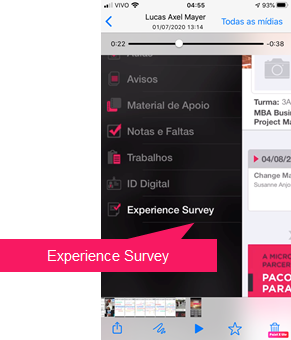